# HW4_analysis_template

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import gspread
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
# This cell is parameters
token = 'BTC'
from_date = '2021-12-01'
to_date = '2021-12-15'
connection_string = 'sqlite:///data/data.db'

In [3]:
# Parameters
from_date = "2021-12-01 00:00:00"
to_date = "2021-12-15 00:00:00"
token = "BTC"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts <= '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

Calculate the hourly return by timestamp.

In [5]:
hourly_return = prices['close'].shift(-1) / prices['close']
prices['hourly return'] = hourly_return.to_frame().shift(1)

Calculate the hourly volatility.

In [6]:
# Formula from the lecture
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [7]:
prices['hourly vol'] = vol_ohlc(prices)

Calculate maximum drawdown up to that hour for each hour.

In [8]:
prices['MDD'] = np.nan
#MDD = (Trough Value - Peak Value)/Peak Value
prices['MDD'][0] = (prices['low'][0] - prices['high'])[0] / prices['high'][0]

for i in range(1, len(prices.index)):
    prices['MDD'][i] = min(prices['MDD'][i-1], (prices['low'][i] - prices['high'])[i] / prices['high'][i])

C:\Users\SIYUAN~1\AppData\Local\Temp/ipykernel_3776/2842081535.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['MDD'][0] = (prices['low'][0] - prices['high'])[0] / prices['high'][0]
C:\Users\SIYUAN~1\AppData\Local\Temp/ipykernel_3776/2842081535.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prices['MDD'][i] = min(prices['MDD'][i-1], (prices['low'][i] - prices['high'])[i] / prices['high'][i])


In [9]:
prices

,open,high,low,close,volume,volumeUSD,token,chain,hourly return,hourly vol,MDD
ts,,,,,,,,,,,
2021-12-01 00:00:00,57321.41,57451.05,56814.34,56987.97,388.482022,2.218430e+07,BTC,BTC,NaN,NaN,-0.011083
2021-12-01 01:00:00,56998.35,57726.45,56705.06,57616.41,599.791578,3.437153e+07,BTC,BTC,1.011028,NaN,-0.017694
2021-12-01 02:00:00,57618.55,57620.00,56972.97,57030.83,591.687200,3.387067e+07,BTC,BTC,0.989837,NaN,-0.017694
2021-12-01 03:00:00,57029.79,57396.87,56841.01,57307.59,702.560364,4.007816e+07,BTC,BTC,1.004853,NaN,-0.017694
2021-12-01 04:00:00,57306.55,57456.82,57026.11,57404.01,859.591535,4.920503e+07,BTC,BTC,1.001682,NaN,-0.017694
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-14 20:00:00,46658.23,47086.98,46649.03,46877.70,783.748050,3.677161e+07,BTC,BTC,1.004810,0.136358,-0.163526
2021-12-14 21:00:00,46875.95,47890.62,46856.37,47805.73,1634.610294,7.759534e+07,BTC,BTC,1.019797,0.142237,-0.163526
2021-12-14 22:00:00,47805.73,48686.91,47773.01,48303.57,1804.082095,8.714276e+07,BTC,BTC,1.010414,0.151148,-0.163526


Plot hourly return, hourly vol, maximum drawdown, close prices and color each day on the graph in a 2x2 grid.

In [10]:
def series_plot(data, events=None, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')

In [11]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

In [12]:
# Had problem to load googlesheet with API Authentication, so I manually copied the data shown in the lecture video.
events = pd.read_csv('data/crypto_events_database.csv')
events['ts'] = pd.to_datetime(events['ts'])
events.set_index('ts', inplace=True)
events.sort_index(inplace=True)

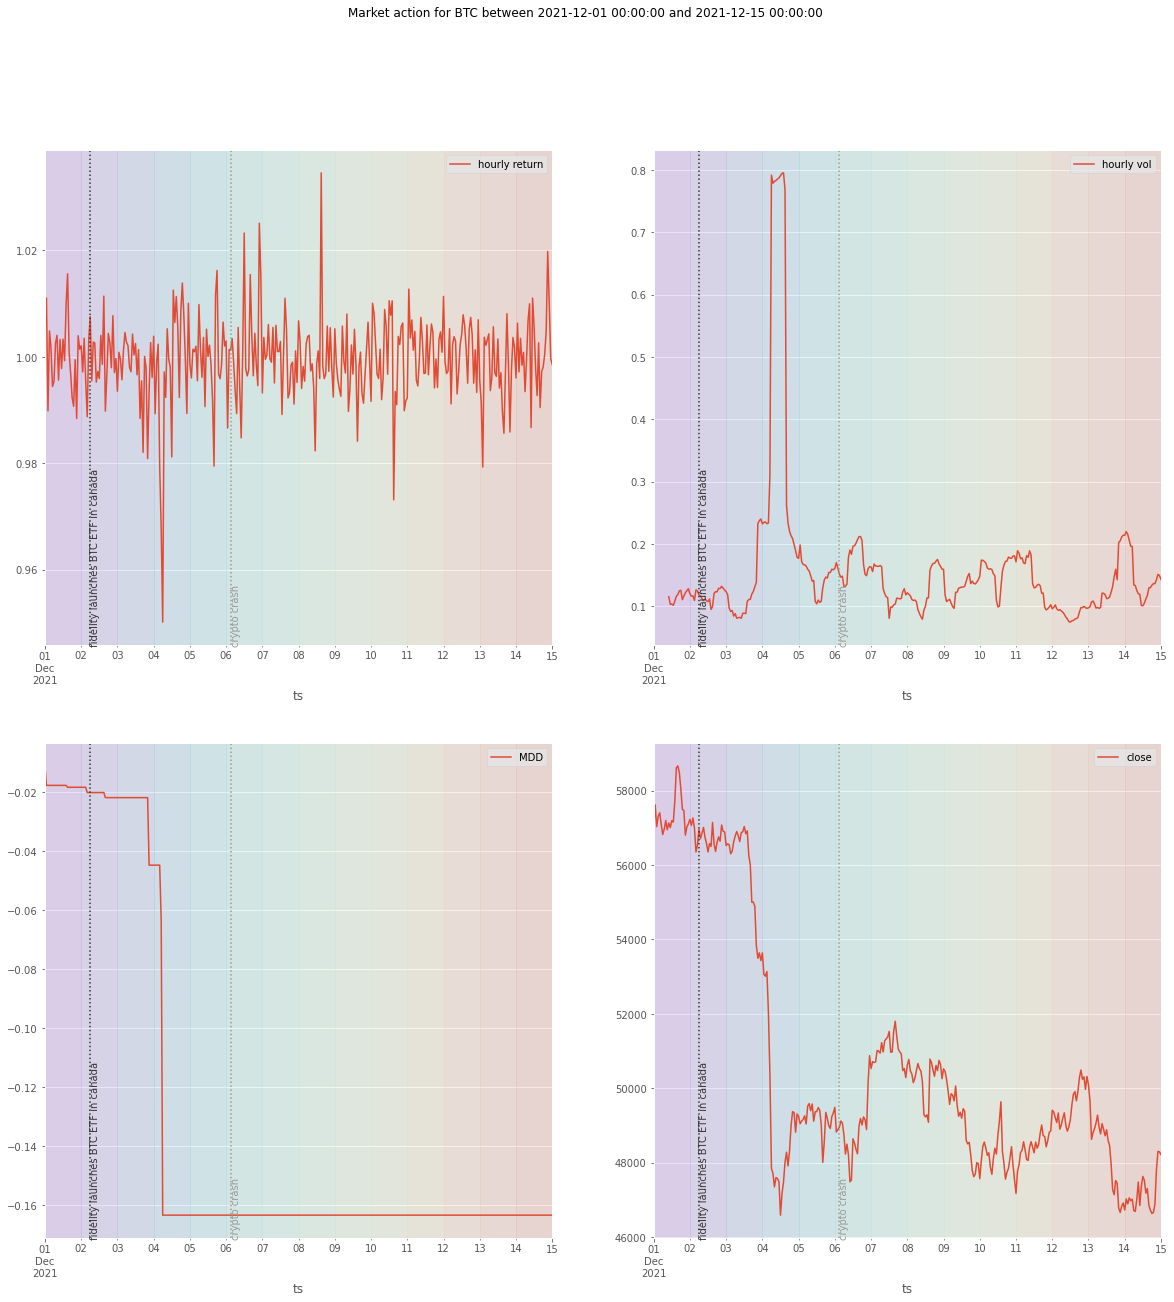

In [13]:
series_plot(prices[['hourly return']], events, ax=ax[0, 0])
series_plot(prices[['hourly vol']], events, ax=ax[0, 1])
series_plot(prices[['MDD']], events, ax=ax[1, 0])
series_plot(prices[['close']], events, ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

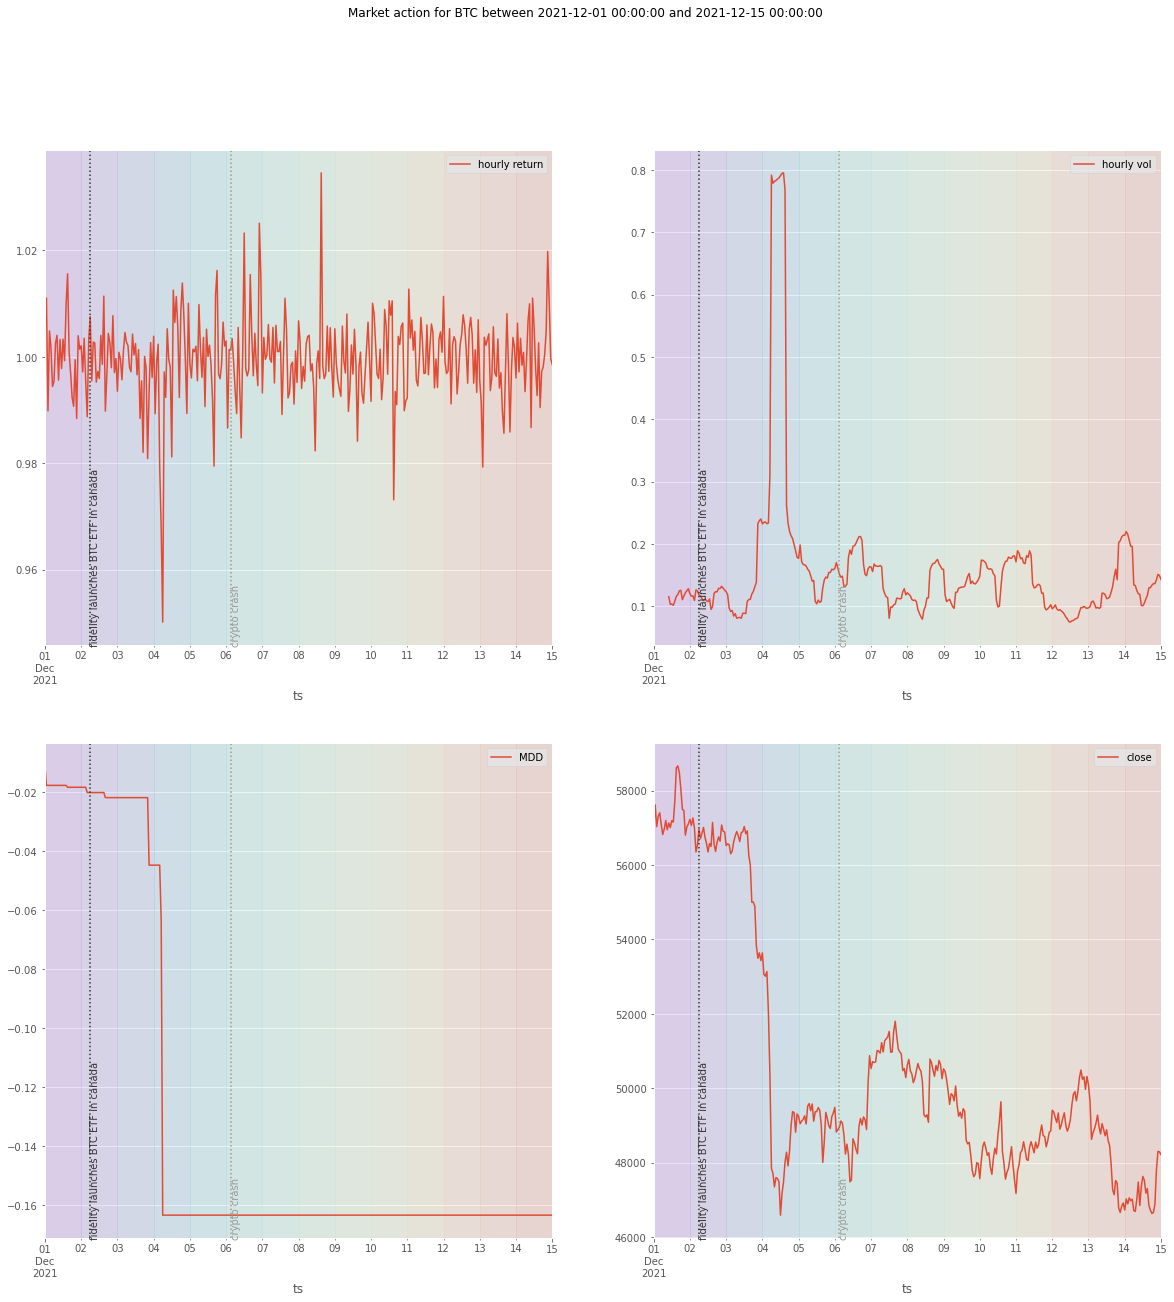

In [14]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)